# Code to fit CEF neutron scattering data from $\rm Pr_2Sn_2O_7$ using PyCrystalField

This notebook compares a PyCrystalField fit with SPECTRE, a different CEF program written by A. Boothroyd. We use data from Princep et al, PRB (2013) http://dx.doi.org/10.1103/PhysRevB.88.104421
and compare to the results in the paper.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pycrystalfield as cef
from scipy.optimize import curve_fit

 *******************************************************
 *                PyCrystalField 2.3.3                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



## Make a point charge model by importing from cif file

The importCIF function gives us both a ligands object ("PCOLig") and a CFlevels object ("Pr").

Note that PyCrystalField automatically identifies the optimal orientation of the axes, and finds only six non-zero CEF parameters.

In [2]:
PSOLig, Pr = cef.importCIF('Pr2Sn2O7.cif','Pr1')
Pr.printEigenvectors()

Importing atoms
   88 atoms added
.cif import complete.
Central ion: Pr3+ at [0.5, 0.5, 0.5]
    AAAH! There is a super-close atom. Removing it...
 Nearest ligand: O2-
   Identified 8 O2- ligands.
   Found 3 fold axis about [1. 1. 1.]
   Found mirror plane: [-0.70710678  0.          0.70710678]

  Axes for point charge model (in ABC space):
        X axis = [-0.5  1.  -0.5] 
        Y axis = [-1.  0.  1.] 
        Z axis = [1. 1. 1.] 

   Creating a point charge model...
B_2 0  =  -0.643611
B_2 1  =  -0.0
B_2 2  =  0.0
B_4 0  =  -0.04072296
B_4 1  =  0.0
B_4 2  =  -0.0
B_4 3  =  0.30489587
B_4 4  =  0.0
B_6 0  =  0.00042397
B_6 1  =  -0.0
B_6 2  =  -0.0
B_6 3  =  0.00386348
B_6 4  =  0.0
B_6 5  =  -0.0
B_6 6  =  0.00402167

 Eigenvalues 	 Eigenvectors
		----------------------------------------------------------------------
0.00000 	|  [ 0.909  0.     0.     0.408  0.     0.    -0.078  0.     0.   ]  |
0.00000 	|  [ 0.     0.    -0.078  0.     0.    -0.408  0.     0.     0.909]  |
14.98

## Calculate the crystal field spectrum to see what it looks like

According to the paper, the data were converted to absolute units. So it should be appropriate to use the "normalizedNeutronSpectrum" function, which does not include the k_i/k_f correction.

<IPython.core.display.Javascript object>


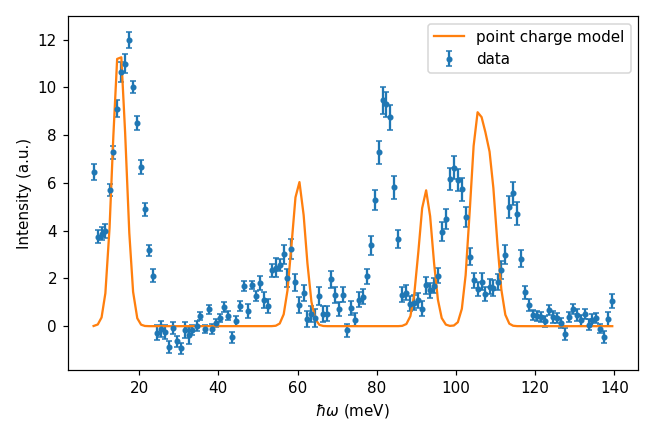

In [3]:
## Import the data
data = np.genfromtxt('Princep_Fig2.txt', unpack=True)

## Calculate the neutron spectrum
CalculatedSpectrum = Pr.normalizedNeutronSpectrum(data[0], Temp=5, ResFunc = lambda x: 4)


###### Plot result
plt.figure(figsize=(6,4))
plt.errorbar(data[0], data[1], data[2], marker='.', ls='none', capsize=2, label='data')
plt.plot(data[0], CalculatedSpectrum*20, label='point charge model')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()

## Define a phenomenological background---the intensity at 107 meV looks too large to be from the Lorentzian tails.

<IPython.core.display.Javascript object>


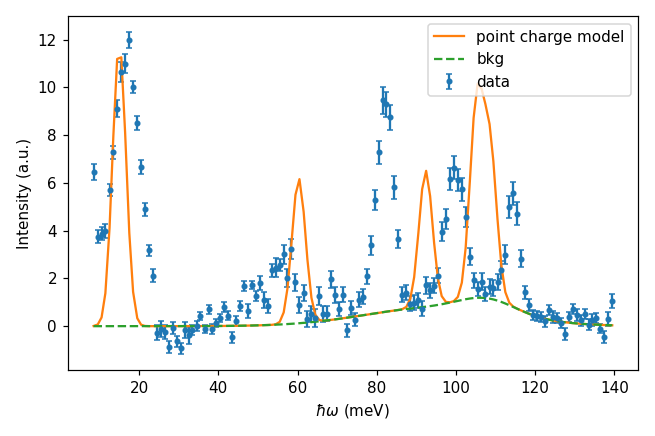

In [4]:
def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def background(x):
    return gaus(x, 35, 95, 18) +  gaus(x, 10, 108, 7) #+ gaus(x, 20, 70, 28) + gaus(x, 15, 58, 12)

###### Plot result
plt.figure(figsize=(6,4))
plt.errorbar(data[0], data[1], data[2], marker='.', ls='none', capsize=2, label='data')
plt.plot(data[0], CalculatedSpectrum*20 + background(data[0]), label='point charge model')
plt.plot(data[0], background(data[0]), label='bkg', ls='--')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()

## Extract peak energies and widths

We do this (a) to define the energy eigenvalues to fit the data to, and (b) to define a phenomenological resolution function for the fits.

[1.01583639e+02 1.67593131e+01 8.21124715e+00 3.48599682e+01
 5.48966860e+01 1.58046720e+01 5.19371922e+01 8.19941043e+01
 5.37588726e+00 3.67999983e+01 9.96417740e+01 6.19084108e+00
 2.02831029e+01 1.14351699e+02 4.10500651e+00 4.95011964e-02]


<IPython.core.display.Javascript object>


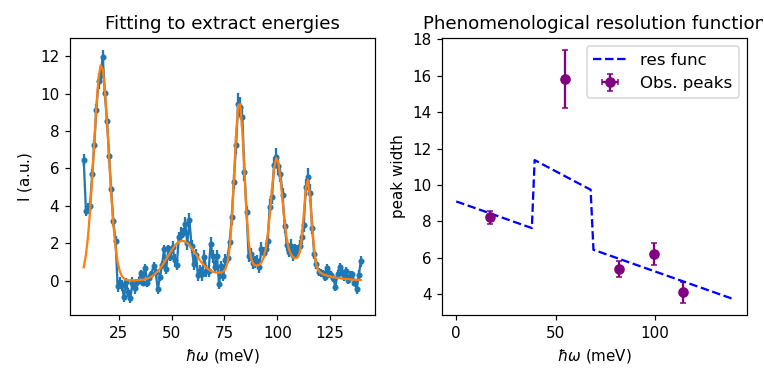

In [5]:
from scipy.special import wofz

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)


def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw):
    '''five Voigt functions for the five peaks. Each has its own Gaussian width,
    but all have the same Lorentzian width "lw".'''
    return voigt(x, a0,x0,w0, lw) +\
           voigt(x, a1,x1,w1, lw) +\
           voigt(x, a2,x2,w2, lw) +\
           voigt(x, a3,x3,w3, lw) +\
           voigt(x, a4,x4,w4, lw)  + background(x)


# Make a guess at the starting parameters:
p0 = [96,17.4,3,  35,56.5,4,  56,82,2,  29,100,2,  25,115,2,  1]

poptinitial, pcovinitial = curve_fit(gausfitfun, data[0][3:], data[1][3:], sigma=data[2][3:], p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))
print(poptinitial)

# Plot results
f, ax = plt.subplots(1,2, figsize=(7,3.5))

ax[0].errorbar(data[0], data[1], data[2], marker='.')
ax[0].plot(data[0], gausfitfun(data[0], *poptinitial), zorder=10)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
ax[0].set_title('Fitting to extract energies')

################################### 
### Now, plot the widths as a function of energy to make a resolution function

ObservedEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObservedWidths, DOW =  [poptinitial[3*i+2] for i in range(0,5)], [uncinitial[3*i+2] for i in range(0,5)]


ax[1].errorbar(ObservedEnergies, ObservedWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
width_popt, width_pcov = curve_fit(straightline, ObservedEnergies, ObservedWidths, 
                                   sigma=DOW, p0=[-0.008,0.16], )

### Define resolution function based on these fits
def resfunc(x):
    w = straightline(x, *width_popt)
    try:
        w[(x > 39)*(x < 69)] *= 1.5
    except TypeError:
        if (x > 39)*(x < 69):
            w*= 2
    return w

xxx = np.linspace(0,data[0][-1],100)
# ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
ax[1].plot(xxx, resfunc(xxx), color='blue', ls='--', label='res func')
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)
ax[1].set_title('Phenomenological resolution function')

plt.tight_layout()



# Fit the data

In [6]:
## Start with a point charge fit

# Step one is figuring out which ions are symmetry equivalent. For this ion, it's easy.
print(PSOLig.bonds)
symequiv = [0,0,1,1,1,1,1,1]

[[ 0.          0.          2.29505392]
 [ 0.          0.         -2.29505392]
 [-1.27023574 -2.20011283 -0.49866932]
 [ 2.54047147  0.         -0.49866932]
 [-2.54047147  0.          0.49866932]
 [ 1.27023574  2.20011283  0.49866932]
 [ 1.27023574 -2.20011283  0.49866932]
 [-1.27023574  2.20011283 -0.49866932]]


In [7]:
def GlobalError(LigandsObject, LigandCharge, gamma, prefactor, symequiv):

    # Build Hamiltonian
    newH = LigandsObject.PointChargeModel(symequiv, LigandCharge=LigandCharge, printB=False)
    newH.diagonalize()

    # Compute error in eigenvalues
    erro=np.nansum((np.unique(np.around(newH.eigenvalues.real,6))[1:] - ObservedEnergies)**2)*100

    # Compute error in neutron spectrum
    erro += np.sum(((prefactor*newH.normalizedNeutronSpectrum(Earray=data[0], Temp = 5, 
                   ResFunc= resfunc, gamma=gamma ) + background(data[0]) -\
                     data[1])/data[2])**2)
    return erro 


#************************************************************
# Fit point charges to neutron data

fitargs = ['LigandCharge','prefactor']

Pr3fit, FitVals = PSOLig.FitChargesNeutrons(chisqfunc = GlobalError,  fitargs = fitargs,
                         LigandCharge = [-2.5,-1.7], gamma=poptinitial[-1], prefactor=20, symequiv=symequiv)

	Fitting...

#*********************************
# Final Stevens Operator Values
B_2 0  =  0.5070855
B_2 1  =  0.0
B_2 2  =  0.0
B_4 0  =  -0.03516375
B_4 1  =  0.0
B_4 2  =  0.0
B_4 3  =  0.29036634
B_4 4  =  0.0
B_6 0  =  0.00034374
B_6 1  =  -0.0
B_6 2  =  -0.0
B_6 3  =  0.00367937
B_6 4  =  0.0
B_6 5  =  -0.0
B_6 6  =  0.00383002

Final Charges:  [-1.65637101 -1.90469188]
Final EigenValues:  [  0.     16.408  16.408  61.022  61.022  89.636  89.636  93.506 109.868]


In [8]:
def err_global(CFLevelsObject, coeff, gamma, prefactor):
    """Global error function used for fitting"""
    
    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)

    # Compute error in eigenvalue
    erro=np.nansum((np.unique(np.around(CFLevelsObject.eigenvalues.real,4))[1:] - ObservedEnergies)**2)*10
    # Note I played around with the factor 30 until I got the lower final error
    
    # Compute error in neutron spectrum
    erro += np.sum(((prefactor*CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0], Temp = 5, 
                   ResFunc= resfunc,gamma=gamma ) + background(data[0]) -\
                     data[1])/data[2])**2)
    return erro


#************************************************************
# Fit to neutron data

FitCoefRes1 = Pr.fitdata(chisqfunc = err_global,  fitargs = ['coeff','prefactor'], 
            coeff = Pr3fit.B,  gamma=poptinitial[-1], prefactor=30, method='Nelder-Mead') # fit from fitted PC
            # coeff = Pr.B,  gamma=poptinitial[-1], prefactor=30, method='Nelder-Mead')   # fit from initial PC

## Fit again with the "Powell" method using the best fit parameters, 
## as starting values, multiplying the prefactor by 6 to "kick" it out
## of the local \chi^2 minimum.
FitCoefRes1a = Pr.fitdata(chisqfunc = err_global,  fitargs = ['coeff','prefactor','gamma'], 
            coeff = FitCoefRes1['coeff'],  gamma=poptinitial[-1], prefactor=FitCoefRes1['prefactor']*6,
                          method='Powell')

Initial err = 94821.2394444166 	Final err = 2550.1900684411335
Initial err = 253643.59114371162 	Final err = 664.2096557197881


## Fit again, only fitting the spectrum (not eigenvalues)

In [9]:
def err_global(CFLevelsObject, coeff, gamma, prefactor):
    """Global error function used for fitting"""
    
    # define new Hamiltonian
    CFLevelsObject.newCoeff(coeff)
    
    # Compute error in neutron spectrum
    erro = np.sum(((prefactor*CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0], Temp = 5,
                   ResFunc= resfunc, gamma=gamma) + background(data[0]) -\
                     data[1])/data[2])**2)
    return erro


#************************************************************
# Fit to neutron data

FitCoefRes2 = Pr.fitdata(chisqfunc = err_global,  fitargs = ['coeff','prefactor','gamma'], 
            coeff = FitCoefRes1a['coeff'],  gamma=FitCoefRes1a['gamma'], 
                         prefactor=FitCoefRes1a['prefactor'], 
                         method='Powell')

print(FitCoefRes2)

Initial err = 663.6639510498056 	Final err = 662.8660883284156
{'coeff': array([-4.40410923e-01, -3.50413722e-02, -4.41029887e-01, -1.40456063e-04,
        4.31609692e-04, -1.50813415e-04]), 'prefactor': array([26.96228117]), 'gamma': array([0.29344826]), 'Chisq': 662.8660883284156}


## Print and plot the results:

In [10]:
# Compare these results to Princep, PRB (2013)
PrincepB =  {'B20': -733/1e3,  # originally in ueV, we convert to meV
             'B40': -36.5/1e3,
             'B43': -383/1e3,  # This term has sign parity because of the three-fold symmetry axis
             'B60': 0.278/1e3,
             'B63': 0.0328/1e3,
             'B66': -4.59/1e3}

Bs = [FitCoefRes2['coeff'], [v for k, v in PrincepB.items()]]
print('Fitted CEF parameters:\n'+'-'*50)
print('Parameter \t This fit \t Princep (2013)\n'+'-'*50)
for i, (n,m) in enumerate([[n,m] for n in range(2,8,2) for m in range(0,n+1, 3)]):
        print('  B_'+str(n)+'^'+str(m)+' \t ', 
              ' \t   '.join([str(np.around(bb[i],4)) for bb in Bs]))


Fitted CEF parameters:
--------------------------------------------------
Parameter 	 This fit 	 Princep (2013)
--------------------------------------------------
  B_2^0 	  -0.4404 	   -0.733
  B_4^0 	  -0.035 	   -0.0365
  B_4^3 	  -0.441 	   -0.383
  B_6^0 	  -0.0001 	   0.0003
  B_6^3 	  0.0004 	   0.0
  B_6^6 	  -0.0002 	   -0.0046


<IPython.core.display.Javascript object>


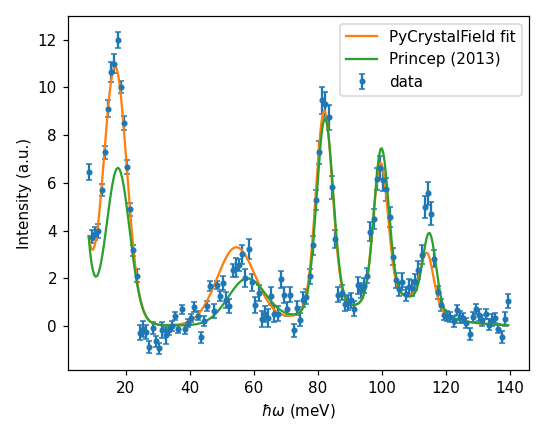

		Eigenstates of PyCrystalField fit:

\begin{table*}
\caption{Eigenvectors and Eigenvalues...}
\begin{ruledtabular}
\begin{tabular}{c|ccccccccc}
E (meV) &$|-4\rangle$ & $|-3\rangle$ & $|-2\rangle$ & $|-1\rangle$ & $|0\rangle$ & $|1\rangle$ & $|2\rangle$ & $|3\rangle$ & $|4\rangle$ \tabularnewline
 \hline 
0.000 & 0.0 & 0.0 & -0.0571 & 0.0 & 0.0 & 0.4873 & 0.0 & 0.0 & 0.8714 \tabularnewline
0.000 & -0.8714 & 0.0 & 0.0 & 0.4873 & 0.0 & 0.0 & 0.0571 & 0.0 & 0.0 \tabularnewline
16.773 & 0.0 & 0.2653 & 0.0 & 0.0 & -0.927 & 0.0 & 0.0 & -0.2653 & 0.0 \tabularnewline
54.539 & -0.4768 & 0.0 & 0.0 & -0.8134 & 0.0 & 0.0 & -0.3332 & 0.0 & 0.0 \tabularnewline
54.539 & 0.0 & 0.0 & -0.3332 & 0.0 & 0.0 & 0.8134 & 0.0 & 0.0 & -0.4768 \tabularnewline
82.052 & 0.0 & 0.0 & -0.9411 & 0.0 & 0.0 & -0.3175 & 0.0 & 0.0 & 0.1159 \tabularnewline
82.052 & 0.1159 & 0.0 & 0.0 & 0.3175 & 0.0 & 0.0 & -0.9411 & 0.0 & 0.0 \tabularnewline
99.671 & 0.0 & -0.7071 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -0.7071 & 0.0 \tabularnewli

In [11]:
## Build a new Hamiltonian from the fitted arguments
xx = np.linspace(data[0][0], data[0][-1], 300)

Pr.newCoeff(FitCoefRes2['coeff'])
FittedSpectrum = Pr.normalizedNeutronSpectrum(xx, Temp=5, ResFunc = resfunc,
                                   gamma=FitCoefRes2['gamma'])*FitCoefRes2['prefactor']  + background(xx)


## Build a new Hamiltonian from Princep et al
PrPrincep = cef.CFLevels.Bdict('Pr3+',PrincepB)
PrincepSpectrum = PrPrincep.normalizedNeutronSpectrum(xx, Temp=5,  ResFunc = resfunc,
                                   gamma=FitCoefRes2['gamma'])*FitCoefRes2['prefactor']  + background(xx)


###### Plot result
plt.figure(figsize=(5,4))
plt.errorbar(data[0], data[1], data[2], marker='.', ls='none', capsize=2, label='data')
plt.plot(xx, FittedSpectrum, label='PyCrystalField fit')
plt.plot(xx, PrincepSpectrum, label='Princep (2013)')
# plot labels
plt.legend()
plt.xlabel('$\\hbar \\omega$ (meV)')
plt.ylabel('Intensity (a.u.)')
plt.tight_layout()


###### Print result in LaTex tables

print('\t\tEigenstates of PyCrystalField fit:\n')
Pr.printLaTexEigenvectors()

print('\n\n\t\tEigenstates of Princep, PRB (2013):\n')
PrPrincep.printLaTexEigenvectors()

# Comments on the results:

The match between PyCrystalField's fit and the data is good, but not perfect (the 115 meV peak is underestimated). If higher temperature data were available showing more transitions, the fit would probably converge much better.

PyCrystalField's fitted Hamiltonian and the fit from Princep, PRB (2013) agree reasonably well with each other. Even though $B_2^0$ are different (-0.733 in Princep vs -0.444 here), the ground state eigenket terms are roughly the same.
Also note that the sign of $B_4^3$ is irrelevant the system has a three-fold symmetry axis about $z$.

#### Note that I had to play with the following values to get the lowest $\chi^2$:
- Weight between the eigenvalue and neutron spectra in the initial fits
- How much to multiply the prefactor in FitCoefRes1a to "kick" the fit out of the local minimum
- The initial point charge fit is not necessary, but adding it reduced the final $\chi^2$ by about 50%. Playing with the initial fitted charge values also helped the fit to converge to a lower $\chi^2$.

None of these dramatically affected the ground state eigenket, but they did slightly improve the final fit.